In [1]:
import pickle
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

matplotlib.rcParams['figure.figsize'] = (16.0, 6.0)
plt.rcParams['pdf.fonttype'] = 3
plt.rc('text', usetex=True)
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

In [2]:
def read_results(result_path):
    with open(result_path, 'rb') as file:
        results = pickle.load(file)
    return results

In [3]:
def get_results(modelname, runtime, device, datasource, directory):
    result = {}
    for root, dirs, files in os.walk(str(directory)):
        for file in files:
            if file.startswith(f'{modelname}_{runtime}_{device}_{datasource}'):
                C = int([part[1:] for part in file.split('_') if part.startswith('c')][-1])
                local_path = os.path.join(root, file)
                filename = f'{modelname}_{runtime}_{device}_{datasource}_c{C}_t50_results.pickle'
                f = os.path.join(directory, filename)
                if os.path.isfile(f):
                    r = read_results(f)
                    result[C] = r['latency_df']
    return result

In [4]:
def createplot(directory: str):
    import matplotlib.ticker as ticker
    # model_names =  ['core', 'gcsan', 'gru4rec', 'lightsans', 'narm', 'repeatnet', 'sasrec', 'sine', 'srgnn',
    #                         'stamp']
    model_names =  ['core', 'gcsan', 'gru4rec', 'lightsans', 'narm', 'noop', 'random', 'repeatnet', 'sasrec', 'sine', 'srgnn',
                           'stamp']
    colors = [ 'b',  'g', 'r',  'w','c', 'm','y','k',]
    markers = ['D', '+','x','D']
    lss=['--','-.',':','-']

    runtimes = ['eager', 'jitopt']
    devices = ['cpu', 'cuda']
    datasource = 'bolcom'

    # We divide the 10 models over rows and columns
    rows=3
    cols=4
    fig, axs = plt.subplots(rows, cols)

    # start sort the models on their p90 latency on eager-CPU for C10M ASC
    my_list = []
    for model_name in model_names:
        results = get_results(model_name, runtime='jitopt', device='cpu', datasource=datasource,directory=directory)
        if len(results) > 0:
            C=1000000
            latency_df = results[C]
            filtered_df = latency_df[latency_df['DateTime'] >= (latency_df['DateTime'].min() + pd.Timedelta(seconds=5))]
            q90 = np.percentile(filtered_df['LatencyInMs'], q=[0.9])
            my_list.append((model_name, q90[0]))

    sorted_list = sorted(my_list, key=lambda x: x[1])
    model_names = [item[0] for item in sorted_list]
    # start sort the models on their p90 latency on eager-CPU for C10M ASC

    # Loop through each subplot and create multiple plots
    for idx, model_name in enumerate(model_names):
        row = idx // 4
        column = idx % 4
        print(f"{model_name} is in row {row}, column {column}")
        ax = axs[row, column]
        for runtime in runtimes:
            for device in devices:
                results = get_results(model_name, runtime, device, datasource, directory)
                if len(results) > 0:
                    q90s = []
                    cs = []
                    qty = []
                    for C, latency_df in results.items():
                        filtered_df = latency_df[latency_df['DateTime'] >= (latency_df['DateTime'].min() + pd.Timedelta(seconds=5))]
                        q90 = np.percentile(filtered_df['LatencyInMs'], q=[0.9])
                        q90s.append(q90)
                        qty.append(len(filtered_df))
                        cs.append(C)
                    color = colors[devices.index(device)]
                    marker = markers[runtimes.index(runtime)]
                    ls = lss[runtimes.index(runtime)]
                    # combine the two lists using zip()
                    combined = zip(cs, q90s, qty)
                    # sort the combined list by the values in the first list
                    sorted_combined = sorted(combined, key=lambda x: x[0])
                    # unzip the sorted values to get the sorted lists
                    cs, q90s, qty = zip(*sorted_combined)
                    label=f'{runtime} {device}'
                    # print(f'{model_name} {label} {list(sorted_combined)}')
                    ax.plot(cs, q90s, color=color, marker=marker, label=label, linestyle=ls, alpha=0.7)    
        ax.set_title(f'Inference latency for {model_name}')
        ax.set_ylim([0.1, 120])
        threshold=40
        ax.axhline(y = threshold, color = 'r', label = f'{threshold}ms')
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.tick_params(axis='both', which='minor', labelsize=14)
        # ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylabel('Latency (ms) p90')
        ax.set_xlabel('C')
        if idx == 0:
            ax.legend(loc=2, fontsize=10, ncol=2)
    fig.suptitle(directory)            
    plt.tight_layout()  # adjust the spacing between subplots
    plt.savefig(f'sbr_models_{datasource}.pdf', bbox_inches='tight')
    plt.show()  # display the figure

KeyError: 1000000

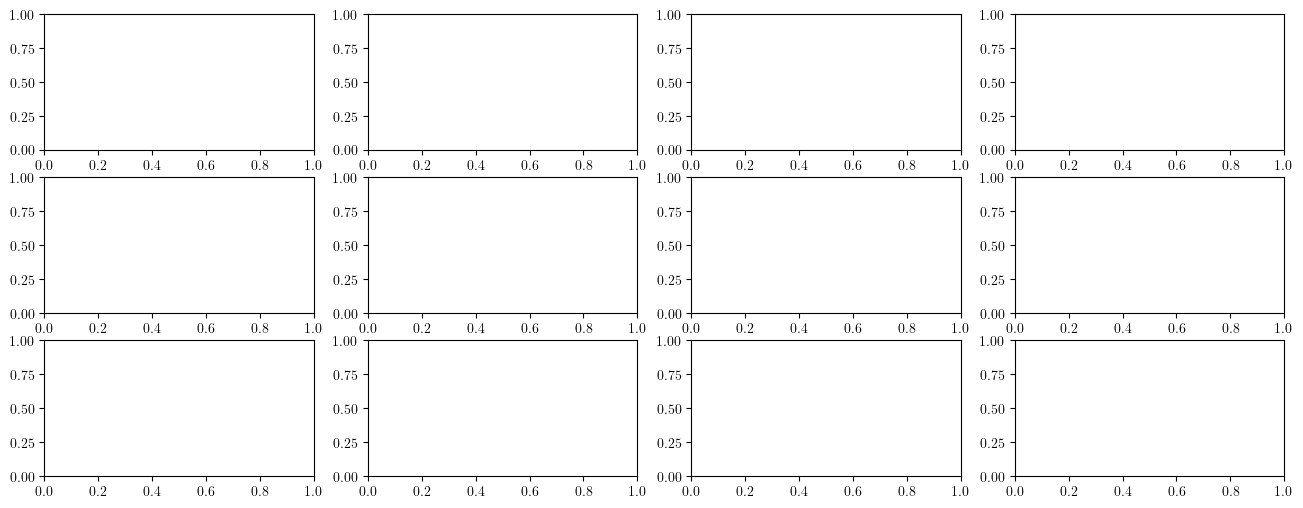

In [6]:
createplot('../../projects/microbenchmark/results')

In [15]:
model_name='random'
runtime = 'eager'
device = 'cuda'
datasource = 'bolcom'
directory='../../projects/microbenchmark/topk_y_2023-04-21/'
results = get_results(model_name, runtime, device, datasource, directory)